# Steam Game Analysis
This data set covers all the games released before 2017 on Valve's Steam platform, pulled from SteamSpy. I would like to see if there are predictors of the estimated player count given other factors. 

In [22]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
raw_data = pd.read_csv('games.csv')

## Data Cleaning

We should first filter out the rows which contain only a few players because this will help reduce the clutter in our dataset.

In [3]:
raw_data.columns

Index(['responsename', 'releasedate', 'metacritic', 'steamspyowners',
       'steamspyownersvariance', 'steamspyplayersestimate',
       'steamspyplayersvariance', 'achievementcount', 'categorysingleplayer',
       'genreisindie', 'genreisaction', 'genreisadventure', 'genreiscasual',
       'genreisstrategy', 'genreisrpg', 'genreissimulation', 'genreissports',
       'genreisracing', 'pricecurrency', 'pricefinal'],
      dtype='object')

In [4]:
data = raw_data[(raw_data['steamspyplayersestimate']>10000) & (raw_data['metacritic']>0)]

We also would like to process the release date in a numeraical method for easier regression later. 

In [5]:
date_sub = data[["responsename", "releasedate"]].dropna()
is_date = date_sub.releasedate.apply(lambda s: (s.lower().find("soon") == -1 and s.lower().find("com") == -1 and s.lower().find("tbd") == -1))
date_sub = date_sub[is_date]

We should double check the formats of the dates.

In [6]:
def isformat(d):
    try:
        pd.datetime.strptime(d, "%b %d %Y")
        print(d)
        return False
    except:
        print(d)
        return True
    return None
date_sub[date_sub.releasedate.apply(isformat)]

Nov 1 2000
May 1 2003
Nov 8 1998
Mar 1 2004
Mar 1 2004
Jun 1 2001
Nov 16 2004
Nov 1 2004
Jul 12 2010
Jun 1 2006
Oct 10 2007
Oct 10 2007
Oct 10 2007
Nov 17 2008
Nov 16 2009
Jul 9 2013
Apr 18 2011
Jul 19 2010
Apr 18 2011
Aug 21 2012
Oct 12 2005
Mar 14 2006
May 14 2009
May 10 2006
May 10 2006
May 10 2006
Jul 14 2005
Aug 23 2006
Sep 29 2006
Sep 19 2008
Feb 7 2006
Feb 7 2006
Jul 6 2006
Jul 6 2006
Jul 26 2006
Oct 16 2006
Apr 3 2007
Apr 1 2006
Apr 30 2009
Oct 25 2006
Oct 25 2006
Aug 4 2011
Aug 3 2007
Aug 3 2007
Aug 3 2007
Jul 11 2006
Oct 29 2010
May 8 2006
Dec 19 2006
Dec 19 2006
Jun 29 2007
Nov 7 2007
Mar 22 2007
Oct 13 2006
Oct 13 2006
Oct 13 2006
Oct 13 2006
Mar 12 2008
Mar 12 2008
Mar 12 2008
Jul 21 2006
Jul 21 2006
Oct 16 2008
Oct 8 2010
Nov 15 2013
Oct 26 2006
Dec 21 2006
Aug 24 2006
Nov 8 2007
Nov 1 2009
Nov 19 2009
Jan 24 2007
Aug 6 2007
Aug 29 2007
Oct 30 2007
Oct 15 2008
Nov 18 2008
May 5 2009
Sep 15 2009
Jul 16 2009
Mar 26 2009
Jun 22 2009
Sep 14 2006
Sep 14 2006
Sep 14 2006
Oct 11

Apr 3 2014
Mar 6 2014
May 17 2016
May 30 2014
Oct 30 2014
May 20 2014
Oct 17 2014
Jan 22 2016
Jul 4 2014
May 21 2014
Jun 6 2014
May 11 2015
Dec 17 2014
Aug 1 2014
Sep 29 2014
Apr 4 2014
Apr 2 2014
Apr 3 2014
Jul 9 2015
Apr 4 2014
Jun 6 2014
Nov 11 2014
Aug 25 2014
Jun 12 2014
Sep 1 2015
Nov 6 2015
Jul 9 2014
Jul 28 2014
Jul 31 2014
Apr 16 2015
Sep 18 2014
Apr 16 2014
Apr 3 2014
Aug 19 2014
Dec 8 2014
Nov 17 2015
Jul 21 2014
Sep 1 2015
Nov 5 2015
Aug 7 2014
May 30 2014
Jan 23 2015
Jun 4 2015
Aug 23 2016
Jul 1 2014
Mar 26 2015
Jun 6 2014
May 18 2015
Jul 23 2014
Jul 13 2015
Oct 9 2014
Aug 5 2014
Nov 7 2014
Aug 21 2014
Sep 24 2014
May 29 2014
Sep 23 2014
May 30 2014
Aug 5 2014
Nov 14 2014
Sep 26 2014
Feb 13 2015
Jan 28 2015
Feb 4 2015
Sep 18 2014
Apr 14 2015
Dec 3 2014
Jun 13 2014
Oct 6 2014
Apr 30 2015
Dec 18 2015
Aug 25 2016
Nov 2014
Jul 25 2014
Aug 7 2014
Jul 31 2014
Feb 13 2015
Jul 14 2014
Apr 30 2015
Apr 21 2016
Jan 15 2015
Mar 28 2016
May 12 2015
Sep 18 2014
Oct 29 2015
Mar 3 2015
Ma

,responsename,releasedate
305,Test Drive Unlimited 2,Feb 2011
668,Blueberry Garden,Jun 2009
687,Puzzle Agent,Jul 2010
904,Darkest of Days,Sep 2009
1180,Silent Hunter 5(r): Battle of the Atlantic,Mar 2010
1228,Flotilla,Apr 2010
1253,Turba,Jul 2010
1268,Age of Wonders II: The Wizards Throne,Oct 2010
1269,Age of Wonders Shadow Magic,Oct 2010
2317,Inquisitor,Aug 2013


In [7]:
def date_impute(d):
    parts = d.split()
    if len(parts) == 2:
        parts.insert(1, "15") # Impute the middle of the month
    date = " ".join(parts)
    return pd.datetime.strptime(date, "%b %d %Y")
date_sub.releasedate = date_sub.releasedate.apply(date_impute)

In [8]:
data_trimmed = pd.merge(date_sub, data.drop("releasedate",axis=1), how="left", on="responsename").drop_duplicates()

In [9]:
data_trimmed

,responsename,releasedate,metacritic,steamspyowners,steamspyownersvariance,steamspyplayersestimate,steamspyplayersvariance,achievementcount,categorysingleplayer,genreisindie,genreisaction,genreisadventure,genreiscasual,genreisstrategy,genreisrpg,genreissimulation,genreissports,genreisracing,pricecurrency,pricefinal
0,Counter-Strike,2000-11-01,88,13033334,92789,9140731,78136,0,False,False,True,False,False,False,False,False,False,False,USD,9.99
1,Day of Defeat,2003-05-01,79,7621102,71499,1709740,34145,0,False,False,True,False,False,False,False,False,False,False,USD,4.99
2,Half-Life,1998-11-08,96,5927504,63206,2268772,39303,0,True,False,True,False,False,False,False,False,False,False,USD,9.99
3,Counter-Strike: Condition Zero,2004-03-01,65,10489261,83543,4127910,52878,0,True,False,True,False,False,False,False,False,False,False,USD,9.99
5,Counter-Strike: Condition Zero,2004-03-01,65,10489261,83543,1870437,35706,0,True,False,True,False,False,False,False,False,False,False,USD,9.99
9,Half-Life: Blue Shift,2001-06-01,71,5368650,60199,662517,21286,0,True,False,True,False,False,False,False,False,False,False,USD,4.99
10,Half-Life 2,2004-11-16,96,9901173,81234,5695963,61979,33,True,False,True,False,False,False,False,False,False,False,USD,9.99
11,Counter-Strike: Source,2004-11-01,88,15433570,100626,11472993,87251,147,False,False,True,False,False,False,False,False,False,False,USD,19.99
12,Day of Defeat: Source,2010-07-12,80,6400269,65635,2895778,44364,54,False,False,True,False,False,False,False,False,False,False,USD,9.99
13,Half-Life 2: Episode One,2006-06-01,87,6298399,65120,2478611,41068,13,True,False,True,False,False,False,False,False,False,False,USD,7.99


Next we would like to check that all the currencies are the same, and if they aren't, convert them. 

In [16]:
print(data_trimmed.pricecurrency.unique())
data_trimmed[data_trimmed.pricecurrency != 'USD']

['USD' nan]


,responsename,releasedate,metacritic,steamspyowners,steamspyownersvariance,steamspyplayersestimate,steamspyplayersvariance,achievementcount,categorysingleplayer,genreisindie,genreisaction,genreisadventure,genreiscasual,genreisstrategy,genreisrpg,genreissimulation,genreissports,genreisracing,pricecurrency,pricefinal
16,Team Fortress 2,2007-10-10,92,37878812,152480,37878812,152480,520,False,False,True,False,False,False,False,False,False,False,NaN,0.0
19,Dota 2,2013-07-09,90,90687580,215972,90687580,215972,0,False,False,True,False,False,True,False,False,False,False,NaN,0.0
22,Alien Swarm,2010-07-19,77,4819841,57083,4819841,57083,66,True,False,True,False,False,False,False,False,False,False,NaN,0.0
74,Vigil: Blood Bitterness(tm),2007-06-29,61,63310,6585,19908,3693,0,True,True,False,False,False,False,True,False,False,False,NaN,0.0
126,Titan Quest,2007-06-26,77,1594238,32977,925265,25146,0,True,False,True,False,False,False,True,False,False,False,NaN,0.0
127,Titan Quest - Immortal Throne,2007-03-05,80,1047402,26749,566386,19683,0,True,False,True,False,False,False,True,False,False,False,NaN,0.0
160,Bloodline Champions,2011-10-28,79,682066,21597,257187,13269,0,True,False,True,False,False,False,False,False,False,False,NaN,0.0
199,Sam & Max 201: Ice Station Santa,2008-05-16,82,146170,10005,30131,4543,0,True,False,False,True,False,False,False,False,False,False,NaN,0.0
200,Sam & Max 202: Moai Better Blues,2008-05-16,80,145273,9974,22777,3950,0,True,False,False,True,False,False,False,False,False,False,NaN,0.0
201,Sam & Max 203: Night of the Raving Dead,2008-05-16,79,145273,9974,20267,3726,0,True,False,False,True,False,False,False,False,False,False,NaN,0.0


It seems that all the prices which are listed as not in USD are free, with a price of 0. Thus, we can ignore the `pricecurrency` column in our later analysis. 

## Preliminary Exploratory Analysis
I think the first thing that needs to be looked at is the proportion of the categorical variables that we have. 

In [23]:
cat_percents = data_trimmed.iloc[:,8:18].aggregate(np.sum) / len(data_trimmed)
cat_percents

categorysingleplayer    0.954323
genreisindie            0.436650
genreisaction           0.498641
genreisadventure        0.314301
genreiscasual           0.090266
genreisstrategy         0.276781
genreisrpg              0.196302
genreissimulation       0.118543
genreissports           0.028276
genreisracing           0.041871
dtype: float64

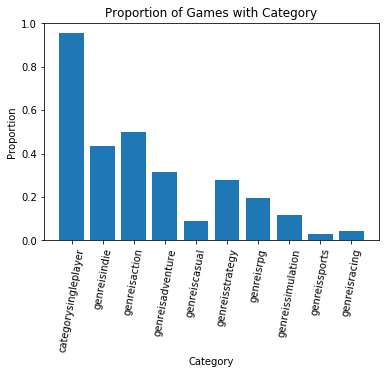

In [37]:
plt.bar(cat_percents.index, cat_percents.values)
plt.xlabel("Category")
plt.xticks(rotation=80)
plt.ylabel("Proportion")
plt.title("Proportion of Games with Category")
plt.show()

In [38]:
# Correlation matrix-like visualization